# CASE 3: **Lorentz-63 attractor**

### 1. Inizialization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

case_study = '3D_lorentz'

### 2. Generate Trajectories


Here it's defined the function that simulates the motion of the Brownian particle in the force field. Particularly, in this case of study, we consider a Brownian particle in a double well trap. The trajectory of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

Comments:

1. The function that simulates the trajectories is *simulate_trajectory*.
2. Lambda functions scale_inputs, rescale_inputs, scale_targets, and rescale_targets must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
sigma0 = 10                               
rho0 = 28                             
beta0 = 2.667
eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
R = 1e-7                                # Radius of the Brownian particle [m]
T = 300
gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 2000                   # Number of samples of the trajectory
Dt = 1e-2                  # Timestep 
oversampling = 5           # Simulation oversampling
offset = 1000              # Number of equilibration timesteps
batch_size = 32            # Number of trajectories

### Define functions to scale and rescale inputs
scale_inputs = lambda x, y, z: [x * 1e+6, y * 1e+6, z * 1e+6]        # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x, scaled_y, scaled_z: [scaled_x * 1e-6,
                            scaled_y * 1e-6, scaled_z * 1e-6]     # Rescales input trajectory to physical units

### Define function to scale and rescale targets
scale_targets = lambda sigma, rho, beta: [sigma, rho, beta]                        # Scales targets to order 1
rescale_targets = lambda scaled_sigma, scaled_rho, scaled_beta: [scaled_sigma, 
                                                                 scaled_rho, 
                                                                 scaled_beta] # Inverse of targets_scaling

def simulate_trajectory(batch_size=batch_size, 
                sigma0=sigma0,
                rho0=rho0,
                beta0=beta0,
                T=T,
                N=N, 
                Dt=Dt, 
                oversampling=oversampling, 
                offset=offset):

    ### Randomize trajectory parameters
    sigma = sigma0 * (uniform(batch_size)+.5)
    rho = rho0 * (uniform(batch_size)+.5)
    beta = beta0 * (uniform(batch_size)+.5)
    gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

    ### Simulate
    dt = Dt / oversampling                 # time step of the simulation
    x = np.zeros((batch_size, N))          # initialization of the x array
    y = np.zeros((batch_size, N))          # initialization of the y array
    z = np.zeros((batch_size, N))          # initialization of the z array
    D = kB * T / gamma                     # diffusion coefficient
    C1 = sigma #* dt                            # sigma
    C2 = rho #* dt                              # rho
    C3 = beta #* dt                             # beta
    C4 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
    X = x[:, 0]
    Y = y[:, 0]
    Z = z[:, 0]
    n = 0

    for t in range(offset):                      # Offset (for some prerun before running)
        X = X + C1*(Y-X)*dt + C4*gauss(batch_size)
        Y = Y + (C2*X-Y-X*Z)*dt + C4*gauss(batch_size)
        Z = Z + (X*Y - C3*Z)*dt + C4*gauss(batch_size)

    for t in range(N * oversampling):            # Simulation 
        X = X + C1*(Y-X)*dt + C4*gauss(batch_size)
        Y = Y + (C2*X-Y-X*Z)*dt + C4*gauss(batch_size)
        Z = Z + (X*Y - C3*Z)*dt + C4*gauss(batch_size) 
            
        if t % oversampling == 0:                # We save every oversampling^th values 
            x[:, n] = X 
            y[:, n] = Y
            z[:, n] = Z
            n += 1
            
    inputs = np.swapaxes([x, y, z],0,1)
    inputs_real = np.swapaxes([x, y, z],0,1)
    targets = np.swapaxes([sigma, rho, beta],0,1)
    target_reals = np.swapaxes([sigma, rho, beta],0,1)

    return inputs, inputs_real, targets, target_reals

<class 'numpy.ndarray'>


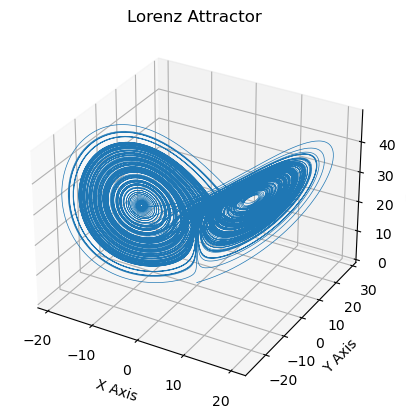

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 100000
batch_size=1

eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
R = 1e-7
T = 300
gamma0 = 6 * np.pi * eta * R
Dt = 1e-2                  # Timestep 
oversampling = 5
gamma = gamma0 * (uniform(batch_size) * .1 + .95)
dt = Dt / oversampling
D = kB * T / gamma
C4 = np.sqrt(2 * D * dt)



xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0,0,0)#(0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
#for t in range(offset):
#    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt + C4 * gauss(batch_size)

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt + C4 * gauss(batch_size)

print(type(xyzs))

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 3. Plot Trajectory Simulation

(2000,)
(2000,)


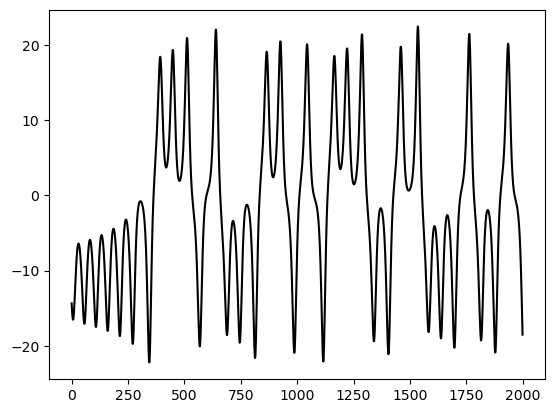

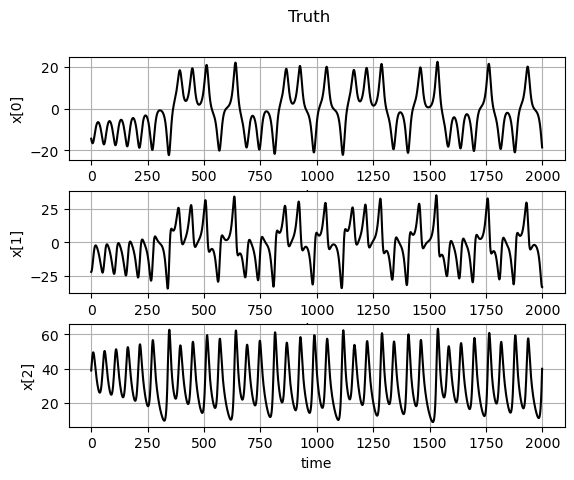

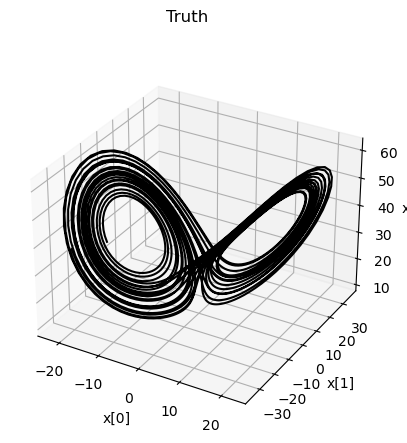

In [5]:
xt = simulate_trajectory()[0][2].T
print(xt[:,1].shape)
t = np.arange(0,N) 
print(t.shape)

plt.plot(t,xt[:,0],'k')
plt.show()

plt.figure().suptitle('Truth')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t,xt[:,i],'k')
    plt.ylabel('x['+str(i)+']')
    plt.xlabel('time')
    plt.grid(True)
    plt.subplots_adjust(hspace=0.3)

fig = plt.figure()
fig.suptitle('Truth')
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt[:,0],xt[:,1],xt[:,2],'k')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_zlabel('x[2]')
ax.grid(True)

(3, 2000)


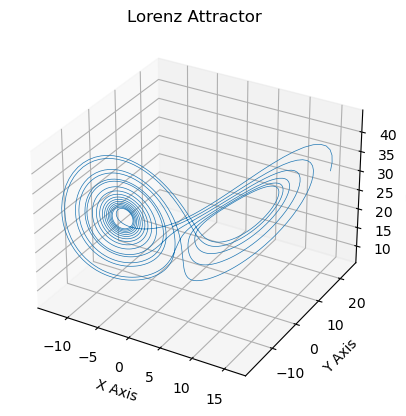

In [7]:
xyzs = simulate_trajectory()[0]
print(xyzs[0].shape)

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs[0], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

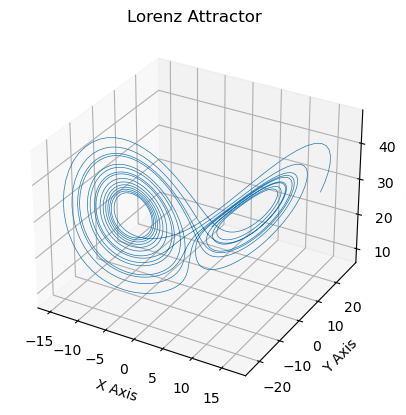

In [8]:
# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs[9], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 4. COMPILE Deep Neural Network

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.

Comments:

1. The parameter input_shape determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter conv_layers_dimensions determines the number and size of LSTM layers.
3. The parameter number_of_outputs determines the number of outputs, i.e. the number of force field parameters to be estimated.

#### GRU

CREATE MODEL

In [24]:
from src_models import models_DNN, train_DNN, test_DNN

In [10]:
### Define parameters of the deep learning network
input_shape = (None, 50)      
gru_layers_dimensions = (250, 50)
number_of_outputs = 3

DNN = 'LSTM'
attention = False

### Create deep learning network
network = models_DNN.create_deep_learning_network(input_shape, gru_layers_dimensions, number_of_outputs, 
                                                      DNN,
                                                      attention)

### Print deep learning network summary
network.summary()

2023-06-15 18:11:05.598130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 18:11:05.598635: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 250)         301000    
                                                                 
 lstm_2 (LSTM)               (None, 50)                60200     
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 361,353
Trainable params: 361,353
Non-trainable params: 0
_________________________________________________________________


/home/david/anaconda3/envs/firstenv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 5. TRAIN Deep Neural Network

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:

The parameter sample_sizes determines the sizes of the batches of trajectories used in the training.
The parameter iteration_numbers determines the numbers of batches used in the training.
The parameter verbose determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [11]:
%%time

sample_sizes = (32, 128, 512) 
iteration_numbers = (3001, 2001, 1001) 
verbose = .1

training_history = train_DNN.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE   375.3179   MAE    14.5887   Time 2223.496914 ms
Sample size     32   iteration number     11   MSE   221.2557   MAE    11.3643   Time 881.244183 ms
Sample size     32   iteration number     21   MSE   197.2332   MAE    10.4846   Time 1064.285040 ms
Sample size     32   iteration number     31   MSE   154.7097   MAE     9.3588   Time 496.435165 ms
Sample size     32   iteration number     41   MSE   154.8315   MAE     9.0340   Time 572.260618 ms
Sample size     32   iteration number     51   MSE   130.7257   MAE     8.2290   Time 596.746445 ms
Sample size     32   iteration number     61   MSE   152.4951   MAE     8.3348   Time 740.378857 ms
Sample size     32   iteration number     71   MSE   169.4601   MAE     9.0074   Time 709.799290 ms
Sample size     32   iteration number     81   MSE   103.5884   MAE     6.9617   Time 778.472900 ms
Sample size     32   iteration number     91   MSE   119.6794   MAE     7.4772   Time 586.085796 m

### 6. TEST MODEL

In [23]:
%%time

number_of_predictions_to_show = 1000
prediction_test = test_DNN.test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

AttributeError: module 'src_models.test_DNN' has no attribute 'test_performance'

### 7. Store Training and Predicted history

In [16]:
normal_values = True

import pickle
def save_data(a, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f) #, protocol=pickle.HIGHEST_PROTOCOL)
    # close file
    f.close()

#from datetime import datetime
#date = datetime.today().strftime('%Y-%m-%d')

## file name
name_train = 'training_history_{}_{}'.format(DNN, case_study)
name_pred = 'prediction_{}_test_{}'.format(DNN, case_study)

if normal_values == False:
    name_train = name_train + '_B'
    name_pred = name_pred + '_B'
if attention == True:
    name_train = name_train + '_attention'
    name_pred = name_pred + '_attention' 

# save train data
save_data(training_history, name_train)
# save test data
#save_data(prediction_test, name_pred)

#load
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

### 8. Plot results

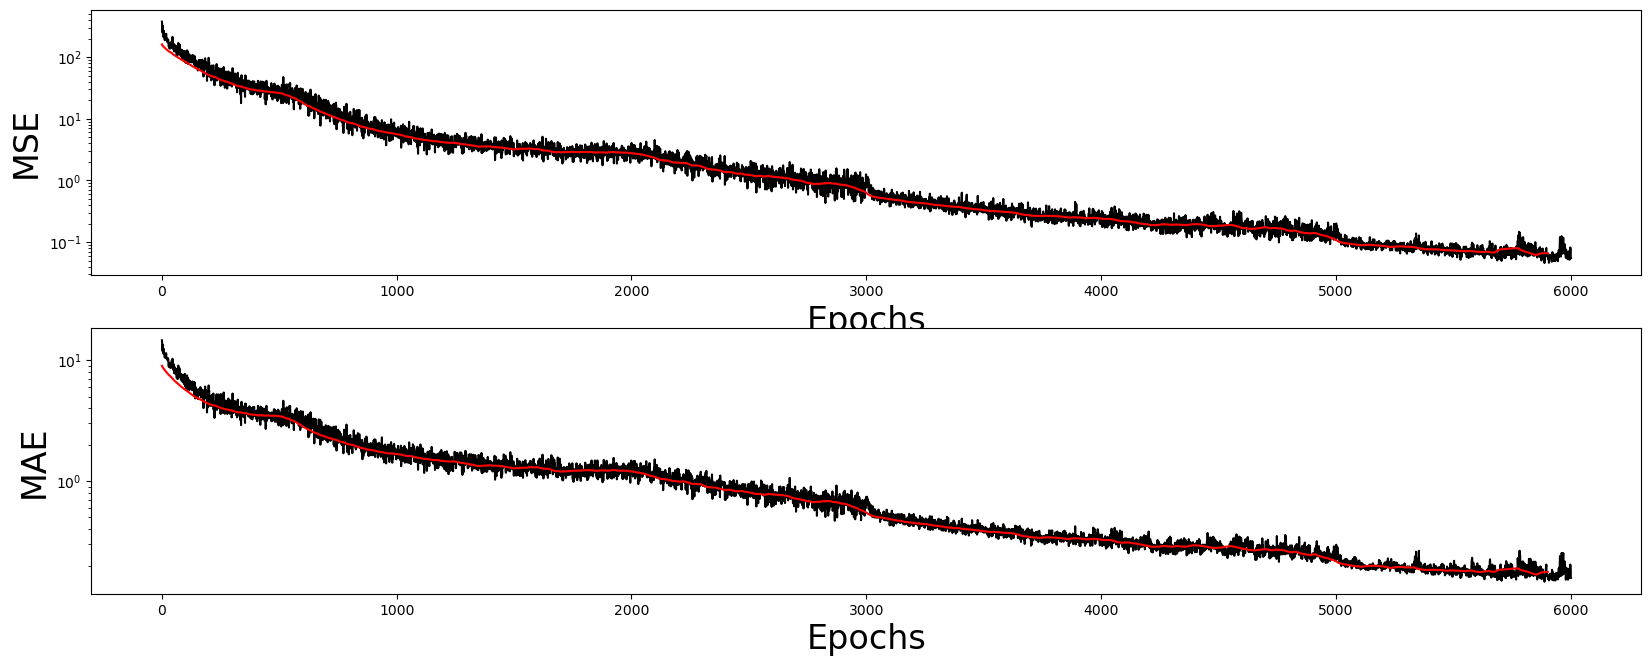

In [25]:
### Plot learning performance
number_of_timesteps_for_average = 100
train_DNN.plot_learning_performance(training_history, number_of_timesteps_for_average)

In [26]:
# average MSE and MAE
avg_mae= round(sum(training_history["MAE"])/len(training_history["MAE"]), 5)
avg_mse=round(sum(training_history["MSE"])/len(training_history["MSE"]), 5)
print('MSE: ',avg_mae)
print('MAE: ',avg_mae)

MSE:  1.1637
MAE:  1.1637


In [27]:
### Plot test performance
test_DNN.plot_test_performance(prediction_test[0], prediction_test[1], prediction_test[2], prediction_test[3], network)

NameError: name 'prediction_test' is not defined

In [28]:
# save DNN
save_dnn_name = 'Network-model_{}_{}'.format(DNN, case_study)

if normal_values == False:
    save_dnn_name = save_dnn_name + '_B'
if attention == True:
    save_dnn_name = save_dnn_name + '_attention'

network.save(save_dnn_name + '.h5')